<font size = "6">**Group Project Report**</font>

**Using common risk factors to predict Heart Disease-the effect of age, serum cholesterol level, and resting blood pressure on disease diagnosis**

**Jacob Wang, Steven Suo, Jiamin Li, Athena Song**

<font size = "5"> Introduction</font>

Heart disease(HD) can be described as any health condition that affects the heart, and it is often fatal if not treated at earlier stages. It can be diagnosed by many risk factors. Therefore, developing methods of the identification of HD based on the risk factors has become a top priority. This project is to develop a model based on the Cleveland dataset that could effectively identify HD based on three risk factors: age, serum cholesterol level, and resting blood pressure. This dataset includes both common risk factors and a number that represent disease status, with 0 being healthy and 1, 2, 3, or 4 being increasing disease stages. This dataset contains 14 attributes (columns) in total, and 303 records for each attribute. 

We are using the Cleveland dataset from the Heart Disease Database to preduct if a patient from Cleveland will have heart disease. The data set has the following variables and columns:

1. age: Age
2. sex: sex 
3. cp: chest pain type
4. trestbps: resting blood pressure in mmHg
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar 
7. restecg: resting electrocardiographic results
8. thalach: maximum heart rate
9. exang: whether exercise induced angina
10. oldpeak: ST depression induced by exercse, relative to rest
11. slope: slope of peak exercise ST segment
12. ca: number of major vessels
13. thal: 3 being normal, 6 being fixed defect, 7 being reversable defect
14. num: diagnosis of heart disease, 0 is none, 1-4 is severity

<font size = "5"> Methods </font>

**Loading, Wrangling, Summarizing, and Splitting the Data**

1. We first imported libraries and then loaded cleveland dataset from the internet using read_csv.
2. Cleaned and tidied the data to make it usable by naming the columns, filling in the ? for NA and adding a new column (diagnosis).
3. Split Data into a training and a testing set to set up a dataset to build our predictor and one for testing it.
4. Grouped and summarized the training set to make a prediction based on the means of our predictor variables.

**Visualizing our Results**

We visualized the relationship between age, cholesterol, and resting heart rate to get a deeper understanding of how these variables predict a diagnosis. We plotted every variable against another one and used diagnosis to color in the points. Based on our visualization, we could conclude that patient diagnosed with heart disease tend to have a higher age, higher cholesterol, and higher resting blood pressure.

**Fitting the Data**

We also wanted to find the best value for the knn classification, which would give the highest accuracy. We create a classifier and perform cross-validation to split the training data, train the model wth one set and use the other to evaluate it. We first used the recipe function to center and scale the data and then performed cross-validation with ten folds using vfold_cv on the training data. We used 10 folds because it would increase out accuracy because if we only split it once, the results strongly depend on one split. Next, we created a k-nearest model to find the best value of k for the k-nearest classification. We add the recipe and model to a workflow and by using tune_grid to fit. Then we found the best k value by filtering for accuracy and plotting a line plot with accuracy estimate on the y-axis and k neighbors on the x-axis giving us a specific k value. 

**Testing the Classifier**

To test out classifier we made a new model specification for the best k value chosen and then applied the recipe made earlier in a workflow and fit the classifier to our training set. Then we used predict on the testing set to evaluate the classifier's prediction accuracy on our testing data set. Finally we took metrics and made a confusion matrix to check the accuracy of our model.

In [1]:
#library imports
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Importing the Cleveland Heart Disease Dataset

In [2]:
set.seed(24)
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


*table 1*

**Tidying and Wrangling the Data**

We need to first change the "?",  to NA so their columns can be assigned the types that we need. The original dataset likely had "?" for unknown values, so we use NA instead. 

We will also create a new column to help in our analysis called "diagnosis". The original data has a column called "num", which classified the severity of heart disease (from 0-4, with 0 meaning none and 4 meaning high severity). The "diagnosis" column could help us identify heart disease easier regardless of severity. The point of our data analysis is to determine whether or not THINGS can predict heart disease so the severity is not really that important. We mainly just want to know if a patient has it (1,2,3) or does not have it (0). It also is good to have a diagnosis column in general because it's a lot easier to just identitfy which patients have heart disease with a simple "they either have it, or they don't".

In [3]:
set.seed(24)
# cleaning, wrangling data

#Chainging all of the "?" to NA so we can clean the data easier
cleveland_tidy <- cleveland_data
cleveland_tidy [cleveland_tidy == "?" ] <- NA

cleveland_tidy <- mutate(cleveland_tidy, diagnosis = as.factor(ifelse(is.na(num), NA, (num > 0)))) |>
                    mutate(sex = as.factor(sex), cp = as.factor(cp), 
                           fbs = as.factor(fbs), restecg = as.factor(restecg),
                           exang = as.factor(exang), thal = as.factor(thal),
                           ca = as.factor(ca), slope = as.factor(slope))
head(cleveland_tidy)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE


*table 2*

**Creating a Training and a Testing Set**

We want to predict our "diagnosis" by stratifying it. We will split our data frame into 75% training and 25% testing. This will allow us train our model with 75% of the data frame and also keep 25% of the data frame to test our set. 

In [4]:
set.seed(24)
cleveland_split <- initial_split(cleveland_tidy, prop = 0.75, strata = diagnosis)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)
nrow(cleveland_training)
head(cleveland_testing)
nrow(cleveland_testing)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE


[1] 227

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2,TRUE
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1,TRUE
48,1,2,110,229,0,0,168,0,1.0,3,0.0,7.0,1,TRUE
54,1,4,140,239,0,0,160,0,1.2,1,0.0,3.0,0,FALSE
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0,FALSE
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1,TRUE


[1] 76

*table 3*
*table 4*

There are 227 rows (75%) in our cleveland_training and 76 rows (25%) in our cleveland_testing. As mentioned above, this gives a really good proportion of data to test our classifier and also enough data to test the classifier later on. 

**Grouping and Summarizing the Data**

We will now use group_by and summarize to find the mean of our predictors for different diagnoses. We do this to find out if there is a noticeable difference between age, cholesterol, and resting blood pressure. 

In [5]:
set.seed(24)
cleveland_summary <- cleveland_training |> 
    group_by(diagnosis) |> 
    summarize(mean_age = mean(age), 
              mean_chol = mean(chol), 
              mean_trestbps = mean(trestbps),
              num_patients = n())
cleveland_summary

diagnosis,mean_age,mean_chol,mean_trestbps,num_patients
<fct>,<dbl>,<dbl>,<dbl>,<int>
FALSE,52.56911,243.2358,129.1138,123
TRUE,56.75000,247.9038,134.4327,104


*table 5*

We can see that patients with heart disease tend to have higher cholesterol, higher resting blood pressure, and higher age. These are what we expect our classifier to predict later on. Our classifier is also fair and unbiased because as we can see in the num_patients column, we have around the same amount of TRUE and FALSE, 104 and 123 respectfully. 

**Visualizing the Predictors and Diagnosis**

We will use a scatter plot with ggplot of different predictors to try and visualize the relatinoship between age, cholesterol, and resting blood pressure to a patient's diagnosis. 

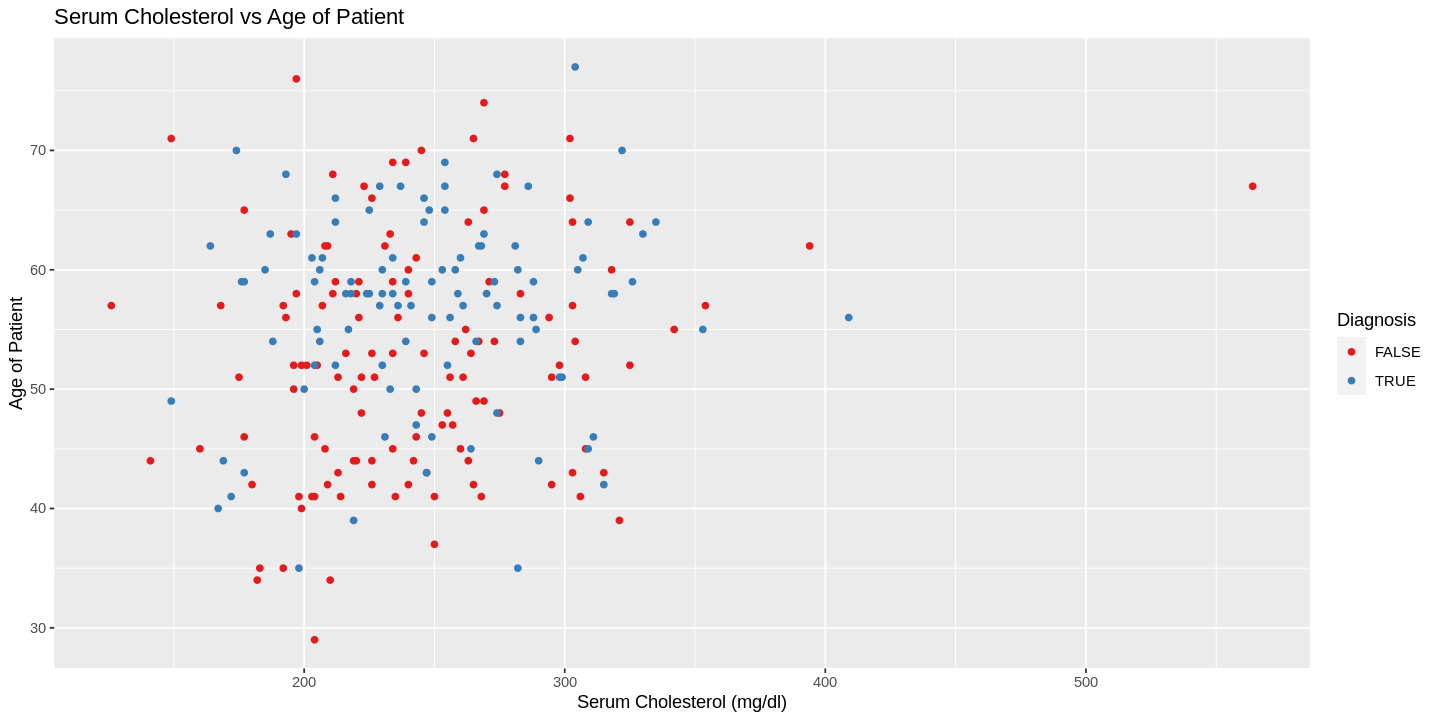

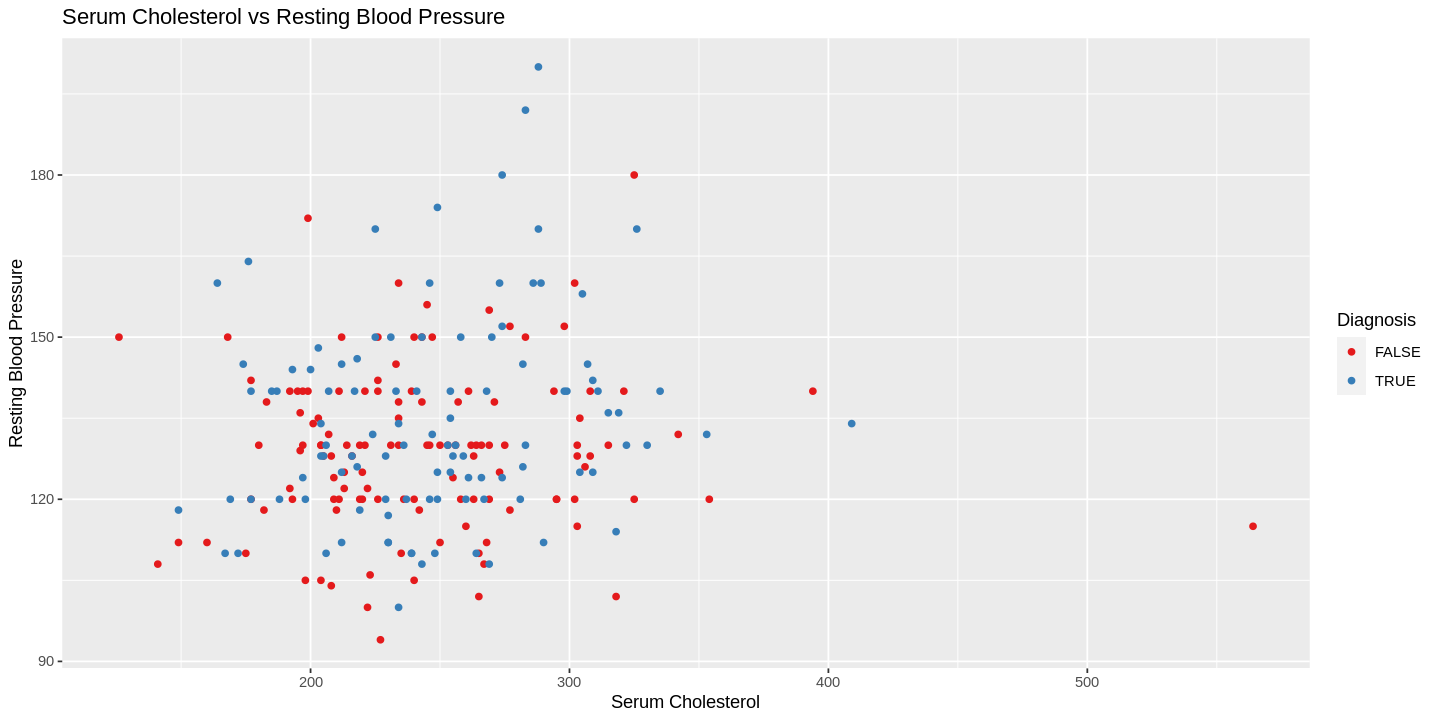

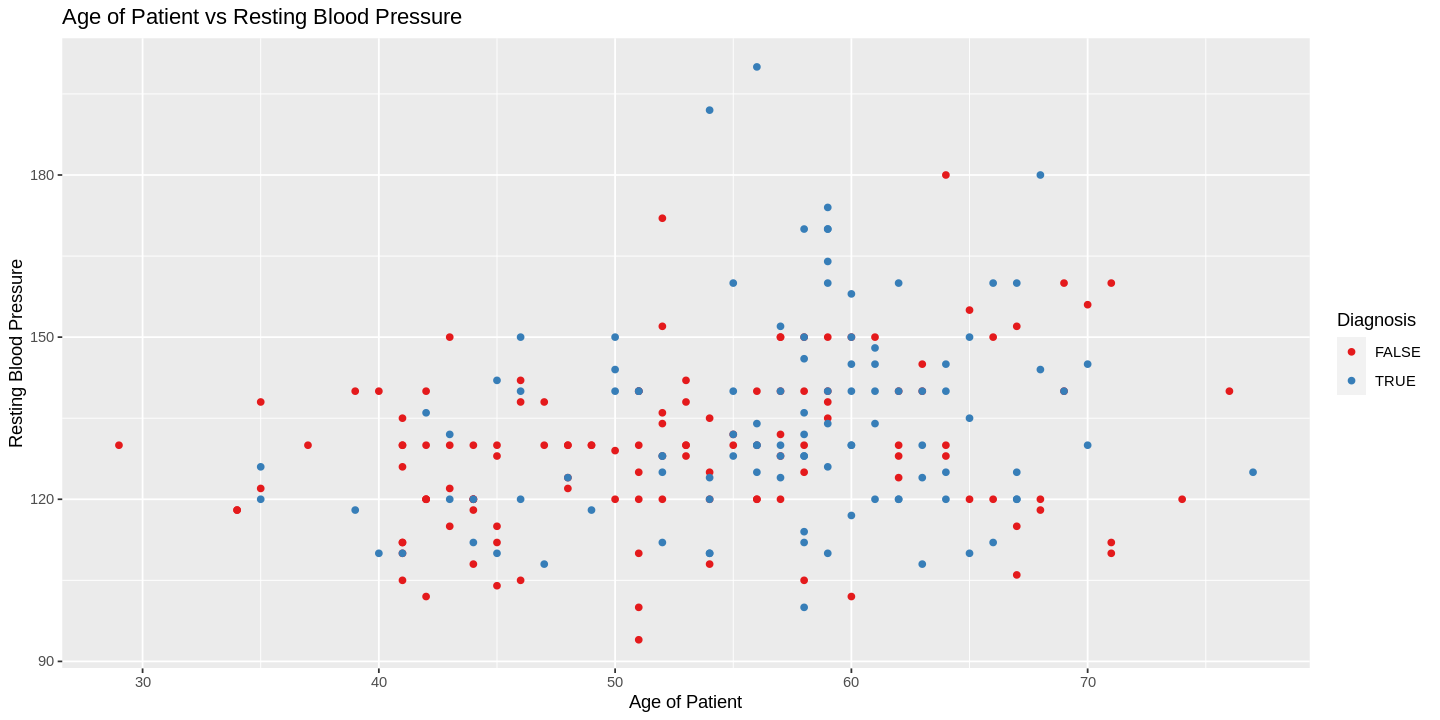

In [6]:
# plotting the data: 
age_vs_chol_plot <- ggplot(cleveland_training, aes(x = chol, y = age, color = diagnosis)) + 
    geom_point() + 
    labs(x = "Serum Cholesterol (mg/dl)", y = "Age of Patient", color = "Diagnosis") + 
    ggtitle("Serum Cholesterol vs Age of Patient") + 
    scale_color_brewer(palette = "Set1")
age_vs_chol_plot

trestbps_vs_chol_plot <- ggplot(cleveland_training, aes(x = chol, y = trestbps, color = diagnosis)) + 
    geom_point() + 
    labs(x = "Serum Cholesterol", y = "Resting Blood Pressure (mmHg)", color = "Diagnosis") + 
    ggtitle("Serum Cholesterol vs Resting Blood Pressure") + 
    scale_color_brewer(palette = "Set1")
trestbps_vs_chol_plot

age_vs_trestbps_plot <- ggplot(cleveland_training, aes(x = age, y = trestbps, color = diagnosis)) + 
    geom_point() + 
    labs(x = "Age of Patient", y = "Resting Blood Pressure (mmHg)", color = "Diagnosis") + 
    ggtitle("Age of Patient vs Resting Blood Pressure") + 
    scale_color_brewer(palette = "Set1")
age_vs_trestbps_plot

*figure 1, figure 2, figure 3*

These graphs show that patients diagnosed with heart disease (blue points TRUE diagnosis) tend to have a higher age, higher cholesterol, and higher resting blood pressure. It also shows that patients without heart disease are the inverse, with lower age, lower cholesterol, and lower resting blood pressure. This visualization confirms what we have in our summary. 

**Tuning and KNN Results**

We want to find the best k value and tune our predictor. We first create a recipe, then make a k nearest neighbors specification to perform cross-validation. Next create a workflow combining with tune_grid. 

In [7]:
set.seed(24)

cleveland_recipe <- recipe(diagnosis ~ chol + age + trestbps, data = cleveland_training) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())
cleveland_recipe

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")
knn_tune

cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diagnosis)
gridvals <- tibble(neighbors = c(1:100))

knn_results <- workflow() |> 
    add_recipe(cleveland_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |> 
    arrange(desc(mean))

head(knn_results)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,mean
<int>,<dbl>
45,0.6212615
46,0.6212615
77,0.6172925
78,0.6172925
79,0.6165349
80,0.6165349


*table 6*

It seems that our best k-value is going to be k = 45 or k = 46 which both give around 62% accuracy. We will plot a line graph of accuracy vs k to find out which one is better. The accuracy of our predictors may not be the best. This will unfortunately affect our analysis because 62% accuracy is quite low. It means that the predictors that we chose are bad to predict the diagnosis of heart disease. This could just be due to a small sample size of around 227. If we had more data we could more accurately assess our predictors. However, since our predictors aren't too good, our final analysis may be a little off. 

**Accuracy Visualization**

We can view which k value is better by using a geom_line plot to see how big of a difference in accuracy there is between the k values 45 and 46. We plot the accuracy vs the neighbors to achieve this analysis

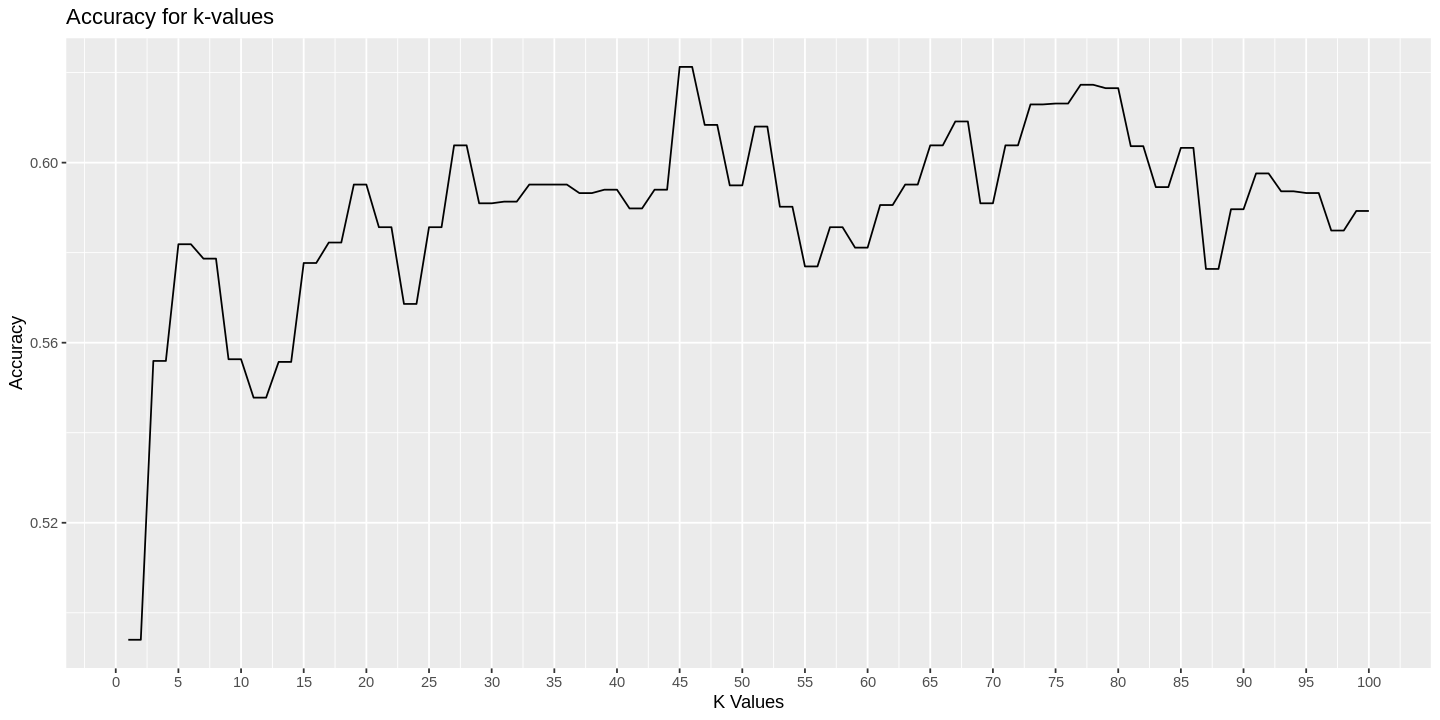

In [8]:
set.seed(24)

accuracy_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) + 
    geom_line() + 
    labs(x = "K Values" , y = "Accuracy", title = "Accuracy for k-values") + 
    scale_x_continuous(breaks = seq(0,100, by = 5))
accuracy_plot

*figure 4*

Based on the graph above, it seems that k = 45 and 46 are both very valid but 46 is a better value for k because the drops on both sides are more similar than on 45. 

**Major Classifier Comparison**

In [9]:
set.seed(24)

cleveland_proportions <- cleveland_training |>
    group_by(diagnosis) |>
    summarize(n = n()) |>
    mutate(percent = (100*n) / nrow(cleveland_training))
cleveland_proportions

diagnosis,n,percent
<fct>,<int>,<dbl>
FALSE,123,54.18502
TRUE,104,45.81498


The FALSE diagnosis represents the majority of the training with a value of 54.2% of all results. Our classifier is more accurate than a majority classifier 

**Fitting the Data**

We can now create a working model for our data set with our k value of the best amount of neighborss

In [10]:
set.seed(24)

fit_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |> 
    set_engine("kknn") |> 
    set_mode("classification")

fit_model <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(fit_spec) |>
    fit(data = cleveland_training)
fit_model

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(46,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3920705
Best kernel: rectangular
Best k: 46

**Testing the Classifier**

We now use our testing set to look at how our classifier works for our testing data set. We will redict using the same fit as before but this time with the cleveland_testing data set. We need to look at its accuracy and its confusion matrix to compare. 

In [20]:
set.seed(24)

predictions <- predict(fit_model, cleveland_testing) |> 
    bind_cols(cleveland_testing)

metrics <- predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class) |> 
    filter(.metric == "accuracy")
metrics

conf_mat <- predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6315789


          Truth
Prediction FALSE TRUE
     FALSE    27   14
     TRUE     14   21

*table 7*

Our classifier was actually 63% accurate and labeled 48 out of 76 observations correctly. It also appears that there is an equal probability for our model to overdiagnose (14) and underdiagnose (14). This is good because it shows that our model is not overly biased and gives false observations to one diagnosis over the other one. We can also see that us creating a new diagnosis column instead of the num is a lot better. By aggregating all heart disease severity diagnosis into one diagnosis class, we decrease the chances of misdiagnosis within the subset of patients. 

<font size = "5"> Discussion </font>

**Summary and Expected Findings**

In summary, we have found out that patient diagnosed with heart disease tend to have a higher age, higher cholesterol, and higher resting blood pressure. An article by Hearth Health and Aging also supports this as it states that people over the age of 65 are more prone to heart disease and heart attacks It also shows that patients without heart disease are the inverse, with lower age, lower cholesterol, and lower resting blood pressure. In our proposal we had initially expected that a higher age, higher cholesterol, and higher resting blood pressure would likely lead to heart disease classification and in our final report we have evidence to support that claim. We expect to find if heart disease can be diagnosed with some common risk factors such as age, serum cholesterol level, and resting blood pressure. Upon completion of this project, we would be able to see the effect of each of the three factors on heart disease; specifically, we could potentially find answers to a variety of questions such as at what age people are more likely to get heart disease, what serum cholesterol level is considered abnormal and therefore can be an indicator of heart disease, or what the resting blood pressure of heart disease patients typically is like. Studies have been shown to support our finding as well through World Health Organisation and United Nations as well as a study done by Janosi, Andras. However, it is possible for the three factors picked to be inadequate for identifying heart disease to begin with; in which case, we would have to explore if some other factors would have been better choices. Our classifier's accuracy turned out to be around 60% in accordance with our predction. This means that it's not really too accurate and can be improved in the future, so there are probably better classifiers out there that better predice heart disease. Our mistakes may have been caused by the fact that the data set we are working on is simply not large enough. There isn't enough data to fully train our classifer and not enough data to test and assess the classifier's accuracy. 

**Impact of our Findings**

Our findings can be used for doctors to diagnose heart disease based on age, cholesterol, and resting blood pressure. By making it easier for doctors to classify heart disease, earlier treatment is possible. Doctors could spend less time diagnosing patients who have a false diagnosis. If we had a higher level of accuracy, this would be a guarantee. False predictions could be fatal so we need a higher accuracy for a prediction. However, having this classifier can be used as a way for doctors to predict and save time. 

**Future Questions this Could Lead to**

1. How can we improve the accuracy of our classifier?
2. Are there better more tell-tale ways to identify heart disease?
3. What other factors other than age, cholesterol, and resting blood pressure impact the chance of a person having heart disease?

**References**

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X. Finegold, J. A., Asaria, P., & Francis, D. P. (2013). 

Mortality from ischaemic heart disease by country, region, and age: statistics from World Health Organisation and United Nations. International journal of cardiology, 168(2), 934-945.https://doi.org/10.1016/j.ijcard.2012.10.046 

Heart Health and Aging: https://www.nia.nih.gov/health/heart-health/heart-health-and-aging#:~:text=and%20bottom%20chambers.-,How%20Your%20Heart%20Changes%20with%20Age,heart%20disease)%20and%20heart%20failure.

Grundy, S. M. (1990). Cholesterol and coronary heart disease: future directions. Jama, 264(23), 3053-3059.

Fox, K., Borer, J. S., Camm, A. J., Danchin, N., Ferrari, R., Lopez Sendon, J. L., ... & Heart Rate Working Group. (2007). Resting heart rate in cardiovascular disease. Journal of the American College of Cardiology, 50(9), 823-830.